In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import networkx as nx
import csv
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from IPython.display import display, HTML
pylab.rcParams['figure.figsize'] = (10, 6)

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Stock Market Clustering

Firstly, we will import our data, which consists of the following two *.csv* files:

* **SP_500_firms.csv:** This file contains all firms currently included in the S&P 500 index.
* **SP_500_close_2015.csv:** This file contains daily stock price data of the firms listed in the previous file for 2015 (without some firms for which data was not available for the entire year).

After importing the data, we inspect the first observations for each dataframe.

In [4]:
# Load companies information
firms = pd.read_csv('SP_500_firms.csv', index_col = 0)
# Load companies stock prices
stockPrices = pd.read_csv('SP_500_close_2015.csv', index_col = 0)

In [5]:
firms.iloc[:5, :]

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology


In [6]:
stockPrices.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-02,156.678596,43.160459,61.986410,86.129228,19.765196
2015-01-05,153.145069,43.170070,60.819874,84.674997,19.490271
2015-01-06,151.511999,42.679830,60.518833,84.064223,19.126976
2015-01-07,152.610267,43.025880,62.964797,85.828689,18.714587
2015-01-08,156.267949,43.910238,63.623323,87.137495,18.901144


## The main part 

### 1. Stock returns

#### Daily returns

In order to analyse how similar those companies perform, we will look at their daily stock price movements. We will assume that companies that have similar stock price movements from day to day, perform similarly. To calculate the daily returns for all stocks in the data we define function `stockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the daily returns of those stocks. The daily returns are calculated based on the following formula:

$$x_t = \frac{p_t - p_{t-1}}{p_{t-1}}$$

In [7]:
def stockReturns(priceDF):
    
    compTickers = priceDF.columns[0: ]    
    priceMat = priceDF.loc[ : , compTickers].as_matrix()    
    diffMat = (priceMat[1: ] - priceMat[ :-1]) / priceMat[ :-1]
    
    return pd.DataFrame(data = diffMat, index = priceDF.index[1: ], \
                        columns = compTickers)    

In [8]:
dailyReturns = stockReturns(stockPrices)
dailyReturns.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
Date,,,,,
2015-01-05,-0.022553,0.000223,-0.018819,-0.016884,-0.013910
2015-01-06,-0.010664,-0.011356,-0.004950,-0.007213,-0.018640
2015-01-07,0.007249,0.008108,0.040417,0.020989,-0.021561
2015-01-08,0.023967,0.020554,0.010459,0.015249,0.009969
2015-01-09,-0.012284,-0.010508,-0.027355,-0.001113,-0.018182


The daily returns of the stocks can be seen in the following figure:

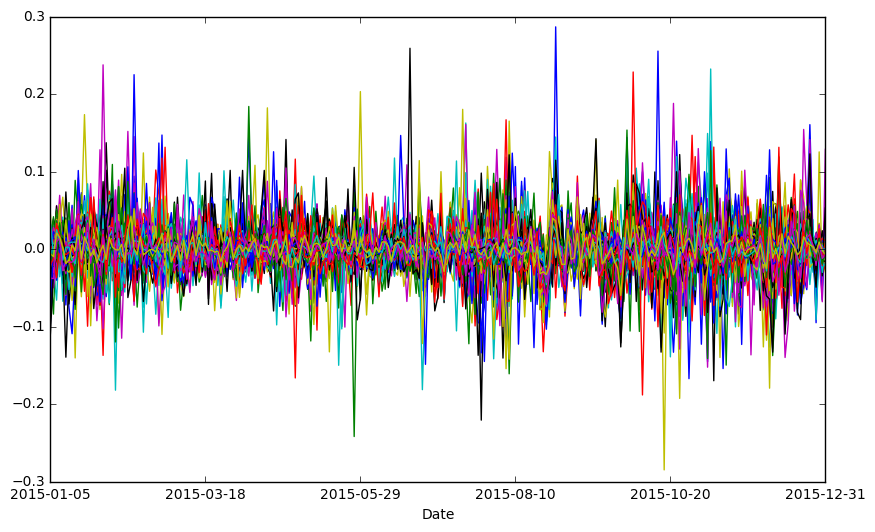

In [9]:
dailyReturns.plot(legend = False);

Next, we will find which companies experienced the **maximum** and **minimum** daily returns,  and what potential evidence there may be for those extreme returns.

To do so, we will merge the daily returns of all companies in one column and then sort this column in descending order.

In [10]:
dailyReturns['Date'] = dailyReturns.index
# Melt data frame so each row is one price change observation
dailyReturnsMelted = pd.melt(dailyReturns, id_vars = "Date")
dailyReturnsMelted = dailyReturnsMelted.rename(columns = {
    'variable':'Symbol',
    'value':'Price Change'
})
# Sort melted dataframe in descending order of price change
dailyReturnsSorted = dailyReturnsMelted.sort_values(by = 'Price Change', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key
dailyReturnsSorted = dailyReturnsSorted.merge(firms, left_on = 'Symbol', \
                                              right_index = True, how = 'left')

The **maximum** daily returns for 2015 were the following:

In [11]:
dailyReturnsSorted.iloc[:10, :]

,Date,Symbol,Price Change,Name,Sector
49359,2015-08-27,FCX,0.286616,Freeport-McMoran Cp & Gld,Materials
121098,2015-06-22,WMB,0.258999,Williams Cos.,Energy
110887,2015-10-14,TRIP,0.255361,TripAdvisor,Consumer Discretionary
53731,2015-01-29,HAR,0.237600,Harman Int'l Industries,Consumer Discretionary
92330,2015-11-06,QRVO,0.232254,Qorvo,Information Technology
121923,2015-10-02,WYNN,0.228389,Wynn Resorts Ltd,Consumer Discretionary
110718,2015-02-12,TRIP,0.224915,TripAdvisor,Consumer Discretionary
57579,2015-05-29,HUM,0.203128,Humana Inc.,Health Care
64457,2015-10-21,KLAC,0.187895,KLA-Tencor Corp.,Information Technology
86408,2015-04-08,PRGO,0.183899,Perrigo,Health Care


Potential evidence for some of the **maximum** daily returns presented above can be found on the following links:

* Trip advisor: http://fortune.com/2015/10/14/tripadvisor-stock-gain-priceline-deal/
* Williams: http://www.forbes.com/sites/antoinegara/2015/06/22/pipeline-giant-williams-rejects-64-a-share-takeover-bid-from-energy-transfer/#318056c339f8
* Harman: http://investor.harman.com/releasedetail.cfm?releaseid=890984 and http://investor.harman.com/releasedetail.cfm?releaseid=893546 
* Qorvo: http://www.qorvo.com/news/2015/qorvo-announces-proposed-1-billion-senior-notes-offering and http://www.bizjournals.com/triad/news/2015/11/06/qorvo-revenue-rises-in-latest-quarter.html

The **minimum** daily returns for 2015 were the following:

In [12]:
dailyReturnsSorted.iloc[-10:, :]

,Date,Symbol,Price Change,Name,Sector
3720,2015-10-28,AKAM,-0.167306,Akamai Technologies Inc,Information Technology
70243,2015-11-09,MNK,-0.169981,Mallinckrodt Plc,Health Care
82309,2015-12-04,NRG,-0.179581,NRG Energy,Utilities
74667,2015-06-26,MU,-0.181515,Micron Technology,Information Technology
88624,2015-02-04,RL,-0.182169,Polo Ralph Lauren Corp.,Consumer Discretionary
123683,2015-10-07,YUM,-0.188324,Yum! Brands Inc,Consumer Discretionary
103364,2015-10-23,SRCL,-0.192767,Stericycle Inc,Industrials
17458,2015-07-24,BIIB,-0.220802,BIOGEN IDEC Inc.,Health Care
74143,2015-05-27,KORS,-0.241954,Michael Kors Holdings,Consumer Discretionary
92817,2015-10-16,PWR,-0.285006,Quanta Services Inc.,Industrials


Potential evidence for some of the **minimum** daily returns presented above can be found on the following links:

* Akami: http://www.fool.com/investing/general/2015/10/28/why-akamai-technologies-inc-fell-hard-on-wednesday.aspx
* Millinckrodt: http://www.bloomberg.com/news/articles/2015-11-09/mallinckrodt-slumps-on-scrutiny-from-valeant-foe-citron-research
* NRG Energy: http://247wallst.com/infrastructure/2015/12/04/nrg-continues-to-fall-as-ceo-steps-down/
* Micron: http://marketrealist.com/2015/06/microns-share-price-fall-19-june-26/
* Yum: http://www.reuters.com/article/us-yum-brands-china-idUSKCN0S11SZ20151007
* Michael Kors: http://money.cnn.com/2015/05/27/investing/michael-kors-earnings-stock-drop/

#### Yearly returns

Next, we will look at the overall performance of the S&P 500 companies over the whole year. Same as before, we create the function `yearlyStockReturns` which takes as input the dataframe of the stock prices and returns a dataframe with the yearly returns of those stocks.

In [13]:
def yearlyStockReturns(priceDF):
    priceMatrix = priceDF.as_matrix()
    # Calculate the yearly returns:
    # (final price - start price) / start price
    TotalPriceChangeMatrix = (priceMatrix[-1: ] - priceMatrix[ :1]) \
                              / priceMatrix[ :1]
    # Convert the result to a dataframe 
    # with the correct index and column names
    TotalPriceChangeDF = pd.DataFrame(TotalPriceChangeMatrix, \
                                      columns = priceDF.columns)
    # Transpose dataframe
    TotalPriceChangeDFtransposed = TotalPriceChangeDF.transpose()
    TotalPriceChangeDFtransposed.columns = ['Price Change']
    
    return TotalPriceChangeDFtransposed

To find which companies performed overall best and worst over the year we will sort the yearly returns of all companies in descending order.

In [14]:
yearlyReturns = yearlyStockReturns(stockPrices)

# Sort them
yearlyReturnsSorted = yearlyReturns.sort_values(by='Price Change', ascending=False)
# Merge on firm data with the symbol as the key (index in both dfs)
yearlyReturnsSorted = yearlyReturnsSorted.merge(firms, left_index=True, right_index=True, how='left')

The companies that performed **best** over the year are the following:

In [15]:
yearlyReturnsSorted.head(10)

,Price Change,Name,Sector
NFLX,1.294549,Netflix Inc.,Information Technology
AMZN,1.190750,Amazon.com Inc,Consumer Discretionary
ATVI,0.942684,Activision Blizzard,Information Technology
AYI,0.676443,Acuity Brands Inc,Industrials
NVDA,0.664514,Nvidia Corporation,Information Technology
GPN,0.600933,Global Payments Inc,Information Technology
HRL,0.559016,Hormel Foods Corp.,Consumer Staples
EXR,0.544469,Extra Space Storage,Financials
VRSN,0.527540,Verisign Inc.,Information Technology
RAI,0.497837,Reynolds American Inc.,Consumer Staples


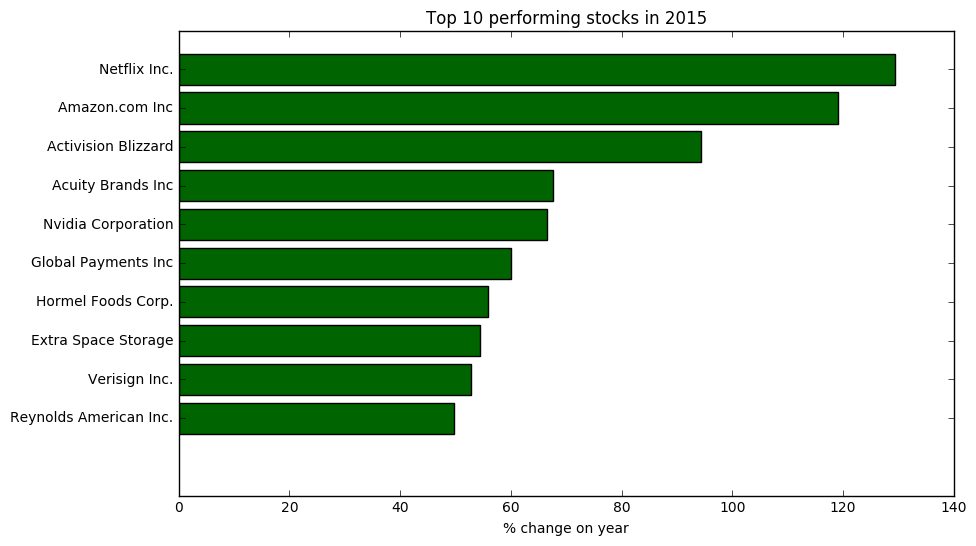

In [16]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][:10])-1,-1,-1)
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][:10]*100,
         align='center', color='darkgreen')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][:10])
plt.xlabel("% change on year")
plt.title("Top 10 performing stocks in 2015");

The companies that performed **worst** over the year are the following:

In [ ]:
yearlyReturnsSorted.tail(10)

In [ ]:
y_pos_top_10 = np.arange(len(yearlyReturnsSorted['Name'][-10:]))
plt.barh(y_pos_top_10, yearlyReturnsSorted['Price Change'][-10:]*100,
         align='center', color='darkred')
plt.yticks(y_pos_top_10, yearlyReturnsSorted['Name'][-10:])
plt.xlabel("% change on year")
plt.title("Bottom 10 performing stocks in 2015");

#### Volatility

Finally, we will try to figure out which companies exhibited **most** and **least** volatility. The volatility of the companies is measured based on the standard deviation of their daily returns over the year. We create the function `volatility` which takes as input a dataframe with the daily returns of the companies and returns a dataframe with the volatility measure of those companies, as defined above.

In [ ]:
def volatility(dailyReturns):
    ##calculate sds and change into panda dataframe
    sdPriceChangeDF = pd.DataFrame(np.std(dailyReturns, axis = 0), \
                                   columns = ['Standard Deviation'])
    
    return sdPriceChangeDF

Next we sort the dataframe of the volatilities in order to find the most and least volatile companies for 2015.

In [ ]:
sdPriceChangeDF = volatility(dailyReturns)

# Sort on standard deviation
sdPriceChangeDFsorted = sdPriceChangeDF.sort_values(by = 'Standard Deviation', \
                                                    ascending = False)
# Merge on firm data with the symbol as the key (index in both dfs)
sdPriceChangeDFsortedfull = sdPriceChangeDFsorted.merge(firms, \
                                                        left_index = True, \
                                                        right_index = True, \
                                                        how = 'left')

The **most volatile** companies for 2015 were the following:

In [ ]:
sdPriceChangeDFsortedfull.head(10)

In [ ]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[0:10].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
plt.show();

The **least volatile** companies for 2015 were the following:

In [ ]:
sdPriceChangeDFsortedfull.tail(10)

In [ ]:
## create list of company ticker names that are in the top 10 most variable
columnlist = sdPriceChangeDFsortedfull[-10:].index.values.tolist()
##create data frame of price data for just the top 10 most variable companies
variablePriceData = stockPrices[columnlist]
##scale based on first price
variablePricesScaled = variablePriceData.divide(stockPrices[columnlist].ix[0])
y_pos_dates = np.arange(len(variablePricesScaled.index))
##Set colour scheme
colors = ['#9970ab','#5aae61','#4393c3','#de77ae','#35978f','#f768a1','#fec44f','#d0d1e6','#08306b','#a50f15']

for i in range(0,len(columnlist)):
    plt.plot(y_pos_dates,variablePricesScaled[columnlist[i]], c=colors[i], label=columnlist[i].format(i=i))
plt.legend(loc='best')
plt.xticks([len(variablePricesScaled.index)/4,
            len(variablePricesScaled.index)*2/4,
            len(variablePricesScaled.index)*3/4,
            len(variablePricesScaled.index)],
           ["Mar-2015","Jun-2015","Sep-2015","Dec-2015"])
plt.legend(loc=5,prop={'size':10})
axes = plt.gca()
axes.set_ylim([0,3])
plt.show();

### 2. Correlations

To find the similarities between stock price movements for different companies, we will calculate the correlation between the returns of different stock prices. For two companies with stock price returns $x, y$ and observations for $n$ days, their correlation is given by the following formula:

$$r_{xy} = \frac{n\sum x_i y_i - \sum x_i \sum y_i}{\sqrt{n\sum x_i^2 - (\sum x_i)^2} \sqrt{n\sum y_i^2 - (\sum y_i)^2}}$$

In order to compute the correlation of the companies, we define function `calCorrelations`, which takes as input a dataframe with the daily returns of the S&P 500 companies and returns their correlations in two different formats:

1. A **correlations matrix**, where each element represents the correlation between the two companies indicated by the specific row and column. 
2. A **graph** where each node represents a company and each edge between two nodes represent the correlation between those two companies.

In [17]:
def calCorrelations(dailyReturn):
    col = dailyReturn.columns
    ncol = len(col)
    corrMat = np.identity(ncol)
    
    G = nx.Graph()
    G.add_nodes_from(col.values)
        
    n = len(dailyReturn)
    for i in range(0, ncol):
        for j in range(i + 1, ncol):
            x = dailyReturn[col[i]]
            y = dailyReturn[col[j]]
            xsum = sum(x)
            ysum = sum(y)
            corrMat[i][j] = (n * sum(x * y) - xsum * ysum) / (np.sqrt(n * sum(x**2) - xsum**2) * np.sqrt(n * sum(y**2) - ysum**2))
            corrMat[j][i] = corrMat[i][j]
            G.add_edge(col[i], col[j], weight = corrMat[i][j])
        
    return pd.DataFrame(data = corrMat, index = col, columns = col), G

In [18]:
corMatrix = calCorrelations(stockReturns(stockPrices))[0]
corMatrix.iloc[:5, :5]

,MMM,ABT,ABBV,ACN,ATVI
MMM,1.000000,0.598666,0.322637,0.632059,0.418550
ABT,0.598666,1.000000,0.483669,0.644081,0.434370
ABBV,0.322637,0.483669,1.000000,0.318051,0.226868
ACN,0.632059,0.644081,0.318051,1.000000,0.462545
ATVI,0.418550,0.434370,0.226868,0.462545,1.000000


In addition, in order to be able to find and print correlations easily between companies, we provide the following helper functions:

1. `cal2CompCor`: It takes as inputs the correlation matrix of the companies, the dataframe with the companies information and the symbols of two companies. It returns their full names and correlation.
2. `calTopLow5`: It takes as inputs the correlation matrix of the companies and the symbol of a company. It returns the symbols and correlations of the five highest and lowest correlated companies.

In [19]:
def cal2CompCor(correlationmatrix, firms, company1, company2):
    print("The correlation between " + firms.loc[company1, 'Name'] + \
          " and " + firms.loc[company2, 'Name'] + " is " + \
          str(correlationmatrix.loc[company1, company2]) + ".")

In [20]:
def highLowCorrelation(correlationmatrix, company):
    namesDict = dict()
    input_file = csv.DictReader(open('SP_500_firms.csv'))
    for row in input_file:
        #print(row)
        namesDict[row['Symbol']] = [row['Name'],row['Sector']]
    
    i = correlationmatrix.columns.get_loc(company)  
    j = correlationmatrix.ix[ : , i]
    high = j.nlargest(6)
    highindex = high.index
    listofhighcomp = []    
    for k in highindex:
        listofhighcomp.append(namesDict[k])
    low = j.nsmallest(5)
    lowindex = low.index
    listoflowcomp = []    
    for k in lowindex:
        listoflowcomp.append(namesDict[k])
       
    dflistofhighcomp = DataFrame(listofhighcomp)
    dfhighindex = DataFrame(highindex)
    dflistofhighcomp = dflistofhighcomp.merge(dfhighindex,right_index=True, left_index=True, how = 'left')
    dfhigh = DataFrame(high)
    table2 = dfhigh.merge(dflistofhighcomp, left_index = True, right_on='0_y', how = 'left')    
    table2.index = table2['0_y'].as_matrix()
    del table2['0_y']
    table2 = table2.rename(columns={company: 'Correlation', '0_x': 'Name of Company', 1: 'Industry'})

    dflistoflowcomp = DataFrame(listoflowcomp)
    dflowindex = DataFrame(lowindex)
    dflistoflowcomp = dflistoflowcomp.merge(dflowindex,right_index=True, left_index=True, how = 'left')
    dflow = DataFrame(low)
    table = dflow.merge(dflistoflowcomp, left_index = True, right_on='0_y', how = 'left')
    table.index = table['0_y'].as_matrix()
    del table['0_y']
    table = table.rename(columns={company: 'Correlation', '0_x': 'Name of Company', 1: 'Industry'})

    return(table2[1:], table)

We will use the functions defined above to explore some of the companies in the tech sector, like *Amazon*, *Microsoft*, *Facebook*, *Apple*, and *Google*. All stocks are affected by macroeconomic environments and thus are correlated with each other, either positively or negatively. There are various factors which determine how correlated two stocks are. 

Usually, stock prices of two companies from the same industry would move in tandem with each other as the market conditions would affect them both in the same way. However, there could also be cases when the market conditions have different effects on companies in the same industry.

In [21]:
pd.DataFrame(highLowCorrelation(corMatrix, 'AMZN')[0])

,Correlation,Name of Company,Industry
GOOGL,0.585553,Alphabet Inc Class A,Information Technology
GOOG,0.584337,Alphabet Inc Class C,Information Technology
SBUX,0.571951,Starbucks Corp.,Consumer Discretionary
V,0.560704,Visa Inc.,Information Technology
MA,0.538708,Mastercard Inc.,Information Technology


In [22]:
pd.DataFrame(highLowCorrelation(corMatrix, 'AMZN')[1])

,Correlation,Name of Company,Industry
SRCL,0.056451,Stericycle Inc,Industrials
RIG,0.060162,Transocean,Energy
SWN,0.082376,Southwestern Energy,Energy
TRIP,0.087684,TripAdvisor,Consumer Discretionary
WFM,0.090700,Whole Foods Market,Consumer Staples


For the top five stocks correlated with Amazon's stocks, $4$ out of the $5$ companies are IT companies and are growth stocks, which is not surprising. However, Starbucks also happens to have a relatively high correlation with Amazon's stocks though it comes from a completely different industry. 

In [23]:
pd.DataFrame(highLowCorrelation(corMatrix, 'MSFT')[0])

,Correlation,Name of Company,Industry
MMC,0.604549,Marsh & McLennan,Financials
PG,0.604204,Procter & Gamble,Consumer Staples
MA,0.590886,Mastercard Inc.,Information Technology
ADP,0.589445,Automatic Data Processing,Information Technology
SBUX,0.583705,Starbucks Corp.,Consumer Discretionary


In [24]:
pd.DataFrame(highLowCorrelation(corMatrix, 'MSFT')[1])

,Correlation,Name of Company,Industry
SRCL,0.028887,Stericycle Inc,Industrials
NRG,0.090761,NRG Energy,Utilities
RIG,0.113785,Transocean,Energy
SWN,0.114787,Southwestern Energy,Energy
URBN,0.128788,Urban Outfitters,Consumer Discretionary


For Microsoft, $2$ out of the top $5$ correlated stocks are from the same industry.

In [25]:
pd.DataFrame(highLowCorrelation(corMatrix, 'FB')[0])

,Correlation,Name of Company,Industry
FISV,0.619667,Fiserv Inc,Information Technology
MA,0.617659,Mastercard Inc.,Information Technology
SBUX,0.598190,Starbucks Corp.,Consumer Discretionary
GOOGL,0.586548,Alphabet Inc Class A,Information Technology
TSS,0.580214,Total System Services,Information Technology


In [26]:
pd.DataFrame(highLowCorrelation(corMatrix, 'FB')[1])

,Correlation,Name of Company,Industry
NEM,-0.002832,Newmont Mining Corp. (Hldg. Co.),Materials
RIG,0.013327,Transocean,Energy
SWN,0.047667,Southwestern Energy,Energy
DO,0.054310,Diamond Offshore Drilling,Energy
CHK,0.058682,Chesapeake Energy,Energy


For Facebook, $4$ out of $5$ of the top correlated companies are in the IT industry. Starbucks also appears in the top 5 for Facebook, surprisingly.

In [27]:
pd.DataFrame(highLowCorrelation(corMatrix, 'AAPL')[0])

,Correlation,Name of Company,Industry
ITW,0.601265,Illinois Tool Works,Industrials
NOC,0.589368,Northrop Grumman Corp.,Industrials
HON,0.576730,Honeywell Int'l Inc.,Industrials
FISV,0.573935,Fiserv Inc,Information Technology
SWKS,0.573350,Skyworks Solutions,Information Technology


In [28]:
pd.DataFrame(highLowCorrelation(corMatrix, 'AAPL')[1])

,Correlation,Name of Company,Industry
RRC,0.112711,Range Resources Corp.,Energy
CMG,0.130501,Chipotle Mexican Grill,Consumer Discretionary
NEM,0.143713,Newmont Mining Corp. (Hldg. Co.),Materials
RIG,0.144045,Transocean,Energy
SWN,0.146811,Southwestern Energy,Energy


For Apple, surprisingly its top $3$ correlated stocks are all from the Industrials sector, with the subsequent $2$ being from the IT industry. These results are interesting, as the companies do not appear to have any relation to Apple.

In [29]:
pd.DataFrame(highLowCorrelation(corMatrix, 'GOOG')[0])

,Correlation,Name of Company,Industry
GOOGL,0.989365,Alphabet Inc Class A,Information Technology
AMZN,0.584337,Amazon.com Inc,Consumer Discretionary
FB,0.569256,Facebook,Information Technology
PGR,0.547913,Progressive Corp.,Financials
MSFT,0.520563,Microsoft Corp.,Information Technology


In [30]:
pd.DataFrame(highLowCorrelation(corMatrix, 'GOOG')[1])

,Correlation,Name of Company,Industry
SRCL,0.017149,Stericycle Inc,Industrials
RIG,0.023044,Transocean,Energy
DO,0.053734,Diamond Offshore Drilling,Energy
RRC,0.056774,Range Resources Corp.,Energy
URBN,0.067461,Urban Outfitters,Consumer Discretionary


In [31]:
pd.DataFrame(highLowCorrelation(corMatrix, 'GOOGL')[0])

,Correlation,Name of Company,Industry
GOOG,0.989365,Alphabet Inc Class C,Information Technology
FB,0.586548,Facebook,Information Technology
AMZN,0.585553,Amazon.com Inc,Consumer Discretionary
PGR,0.556862,Progressive Corp.,Financials
MA,0.515583,Mastercard Inc.,Information Technology


In [32]:
pd.DataFrame(highLowCorrelation(corMatrix, 'GOOGL')[1])

,Correlation,Name of Company,Industry
RIG,0.009523,Transocean,Energy
RRC,0.043924,Range Resources Corp.,Energy
DO,0.045733,Diamond Offshore Drilling,Energy
SWN,0.062425,Southwestern Energy,Energy
SRCL,0.062576,Stericycle Inc,Industrials


Alphabet Inc. is the parent company of Google and has two types of stocks (`GOOG` and `GOOGL`), which are Class A and Class C share respectively. The difference between the two is that the owner of Class A share are allowed to vote, whereas the owners of Class C shares are not. 
The top 5 correlated shares for `GOOG` and `GOOGL` are the same, aside from Microsoft for `GOOG` and Mastercard Inc for `GOOGL`. It is not surprising that the highest stock correlation for `GOOG` is `GOOGL` at 0.98 and vice versa, since they are under the same parent company.

Most of the lowest correlated stocks for each of the aforementioned tech companies are from companies in the Energy/Industrials/Materials sector, whose stock prices move in conjunction with commodity prices such as oil and gas based on global supply and demand. Thus, it is not surprising that their stock prices have such low correlation with the stock prices of tech companies.

For the companies which appear to have no relation to the above tech companies but have correlated stocks, this may be due to chance, as the time period we are looking at is only a year. It would be interesting to see if this correlation is sustained throughout a longer time period, to see if there is really a correlation between the two stocks. This will be investigated further in the in-depth analysis section of the report.

Another interesting thing to note is that there appears to be no stocks in the S&P 500 which are strongly negatively correlated with the stocks from above tech companies. 

### 3. Clustering algorithm

We will now use the similarity information of the companies based on their correlations to divide them into clusters. The clusters will indicate companies with similar performance over the year 2015 and will be performed using a *greedy* algorithm design which is described as follows:

1. Sort the edges in the graph by their weight (ie the correlation)
2. Create a single-node set from each node in the graph
3. Repeat k times:
    1. Pick the highest-weight edge
    2. Merge the sets containing the source and the destination of the edge
    3. Repeat from A. with the next-highest weight edge
    
4. Return the remaining sets

To perform the clustering, we define two new functions, `sortCorrelations` and `clusteringAlg`, that perform the following tasks:

* `sortCorrelations`: Takes as input the correlation matrix of the companies and returns an ordered list of tuples in descending order based on the correlations of the companies. Each tuple has the following format:

$$(correlation, company_1, company_2)$$

* `clusteringAlg`: takes as input the list of tuples created by the previous function and a constant $k$, which represents the iterations of the algorithm, and clusters the companies based on the algorithm described previously. The output of the function is a list of sets, where each set represents a cluster of companies and a list of integers where each integer represents the number of clusters at each iteration.

In [33]:
def sortCorrelations(corMatrix):
    n = int(corMatrix.shape[0])
    corList = []
    for i in range(1, n):
        for j in range(0, i):
            corList.append((corMatrix.iloc[i, j], corMatrix.columns.values[i], \
                            corMatrix.columns.values[j]))
    return sorted(corList, reverse = True)

In [34]:
def clusteringAlg(corList, k = 0):
    """
    Input:  
    corList: The ordered list of tuples which include the
              correlations between firms and the firms themselves
    k: The number of iterations for the clustering algorithm
    Output: 
    A list of sets where each set represents an individual 
    cluster
    """
    # Initialize the list of sets. Each set represents a cluster
    # which initialy includes only one firm
    sets = []
    noOfClusters = []
    for i in range(len(corList)):
        if not({corList[i][1]} in sets):
            sets.append({corList[i][1]})
        if not({corList[i][2]} in sets):
            sets.append({corList[i][2]}) 
    inNoOfClusters = len(sets)
    # Repeat the algorithm k times
    # In each iteration we check the k-th tuple of correlations list
    # and whether the 2 firms in that tuple are already in the same
    # set. If they do, we move on to the next tuple, otherwise we merge
    for j in range(min(k, len(corList))):
        nd1 = corList[j][1]
        nd2 = corList[j][2]
        fl1, fl2 = False, False 
        noOfClusters.append(inNoOfClusters - len(sets))
        for i in range(len(sets)):
            if (nd1 in sets[i]) and fl1 == False:
                idx1 = i
                fl1 = True
            if (nd2 in sets[i]) and fl2 == False:
                idx2 = i
                fl2 = True
        if idx1 != idx2:
            sets[idx1] = sets[idx1].union(sets[idx2])
            sets.remove(sets[idx2])
    # Return the final list of sets
    return sets, noOfClusters

In [35]:
corList = sortCorrelations(corMatrix)

In [36]:
clusters, noClusters = clusteringAlg(corList, k = 10000)

In the following diagram we observe how the number of clusters increases as the number of iterations increases from $1$ to $10,000$. We define clusters as groups of companies that include more than one company. We observe that the slope of the line is more steep during the first iterations but as the number of iterations increases, the number of clusters increases at a slower pace. 

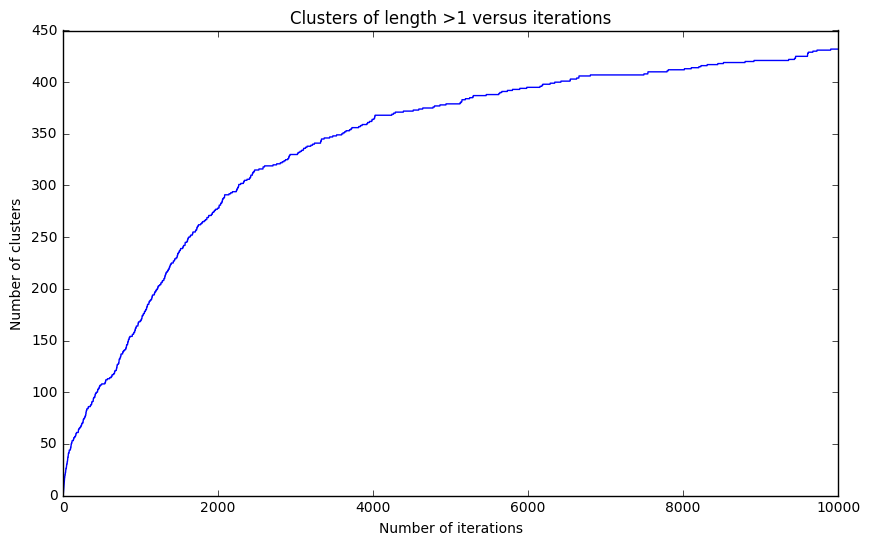

In [37]:
t = np.arange(1, 10001)
plt.plot(t, noClusters, '-')
plt.xlabel('Number of iterations')
plt.ylabel('Number of clusters')
plt.title('Clusters of length >1 versus iterations')
plt.show()

The clustering algorithm implemented above is called **single-linkage clustering** and is one of the many methods of **hierarchical clustering**. Single-linkage clustering is based on agglomerative clustering. It involves starting with each firm in a cluster of its own and then combining two clusters at each iteration of the algorithm. It chooses the two clusters that are 'close to' i.e. highly correlated with each other.

Single-linkage clustering is the same as the **Kruskal's algorithm** used for minimum spanning trees. The algorithm deals with a connected weighted graph. It first finds the edge with the lowest weight and then adds edges in increasing order of weight until it forms a minimum spanning tree which is a subset of the tree that connects all the vertices and minimizes the total weight of all the edges. The Kruskal's algorithm is similar to single-linkage clustering because it also chooses vertices that are 'close to' each other, where closeness is defined by the weight of the edge between vertices.

In order to evaluate our clustering algorithm, we will focus on the resulting clusters for different values of $k$ and see if the companies included in those have similarities between them and whether their stock prices and daily returns perform in a similar way.

For that purpose we define the function `companyTracker` which take as input the correlation list previously computed, the symbol of a company, the dataframe which contains the companies information and three integers, which specify the different values of $k$ for which we will execute the clustering algorithm.

In [38]:
def companyTracker(corList, company, firms, ks, kf, kint):
    kValues = np.arange(ks, kf, kint)
    sets = []
    for k in kValues:
        clusters = clusteringAlg(corList, k)[0]
        print('k = ' + str(k))
        for i in range(len(clusters)):
            if company in clusters[i]:
                if len(clusters[i]) == 1:
                    display(firms.loc[ticker, :])
                else:
                    display(firms.loc[clusters[i], :].sort_values(['Sector', 'Name']))

We will see how the aforementioned companies are clustered when the number of iterations $k = \{30, 50, 100, 500, 1000\}$.

In [39]:
companyTracker(corList, 'BAC', firms, 30, 60, 30)

k = 30


,Name,Sector
Symbol,,
BAC,Bank of America Corp,Financials
C,Citigroup Inc.,Financials
JPM,JPMorgan Chase & Co.,Financials


In [40]:
companyTracker(corList, 'BAC', firms, 50, 100, 50)

k = 50


,Name,Sector
Symbol,,
BBT,BB&T Corporation,Financials
BAC,Bank of America Corp,Financials
C,Citigroup Inc.,Financials
CMA,Comerica Inc.,Financials
HBAN,Huntington Bancshares,Financials
JPM,JPMorgan Chase & Co.,Financials
KEY,KeyCorp,Financials
PNC,PNC Financial Services,Financials
RF,Regions Financial Corp.,Financials


In [41]:
companyTracker(corList, 'BAC', firms, 100, 200, 100)

k = 100


,Name,Sector
Symbol,,
BBT,BB&T Corporation,Financials
BAC,Bank of America Corp,Financials
C,Citigroup Inc.,Financials
CMA,Comerica Inc.,Financials
FITB,Fifth Third Bancorp,Financials
GS,Goldman Sachs Group,Financials
HBAN,Huntington Bancshares,Financials
JPM,JPMorgan Chase & Co.,Financials
KEY,KeyCorp,Financials


In [42]:
companyTracker(corList, 'BAC', firms, 500, 1000, 500)

k = 500


,Name,Sector
Symbol,,
AFL,AFLAC Inc,Financials
AMP,Ameriprise Financial,Financials
AON,Aon plc,Financials
BBT,BB&T Corporation,Financials
BAC,Bank of America Corp,Financials
BRK-B,Berkshire Hathaway,Financials
SCHW,Charles Schwab Corporation,Financials
CB,Chubb Limited,Financials
CINF,Cincinnati Financial,Financials


In [43]:
companyTracker(corList, 'BAC', firms, 1000, 2000, 1000)

k = 1000


,Name,Sector
Symbol,,
SNA,Snap-On Inc.,Consumer Discretionary
SWK,Stanley Black & Decker,Consumer Discretionary
AFL,AFLAC Inc,Financials
AMG,Affiliated Managers Group Inc,Financials
AIG,"American International Group, Inc.",Financials
AMP,Ameriprise Financial,Financials
AON,Aon plc,Financials
AJG,Arthur J. Gallagher & Co.,Financials
BBT,BB&T Corporation,Financials


After running the clustering algorithm, for increasing values of $k$, it is observed that as $k$ increases more elements are added to the existing clusters and more new clusters are formed. Clusters are formed with stocks belonging to firms within the same industry. However, after a certain value of $k$, we see clusters merging and becoming more 'broad' – for example, what was initially two clusters – insurance and banking – becomes a general 'finance' cluster. 

In the above tables, *Bank of America Merrill Lynch* was tracked for different values of $k$ to see how the composition of its cluster changes when $k=\{30, 50, 100, 500, 1000\}$. For values of $k$ equal or less than $500$, we can only see companies from the Financial sector within its cluster. For $k = 1000$, firms from the Consumer Discretionary, Industrial and Information Technology sector join the sector. This may happen because one or two stocks from these indsutries may have a lower correlation with companies from the Financial sector.

Next, we define the function `plotSetPrices` which takes as inputs the stock prices of the S&P 500 companies, the resulting clusters of the clustering algorithm and the symbol of a company. What the function does is to plot the normalised prices of all the the companies that belong to the cluster of the specified company.

In [44]:
def plotSetPrices(stockPrices, clusters, company):
    
    for i in range(len(clusters)):
            if company in clusters[i]:
                normPrices = stockPrices.loc[:, clusters[i]]
                normPrices = normPrices / normPrices.iloc[0, :]
                normPrices.plot(legend = True);

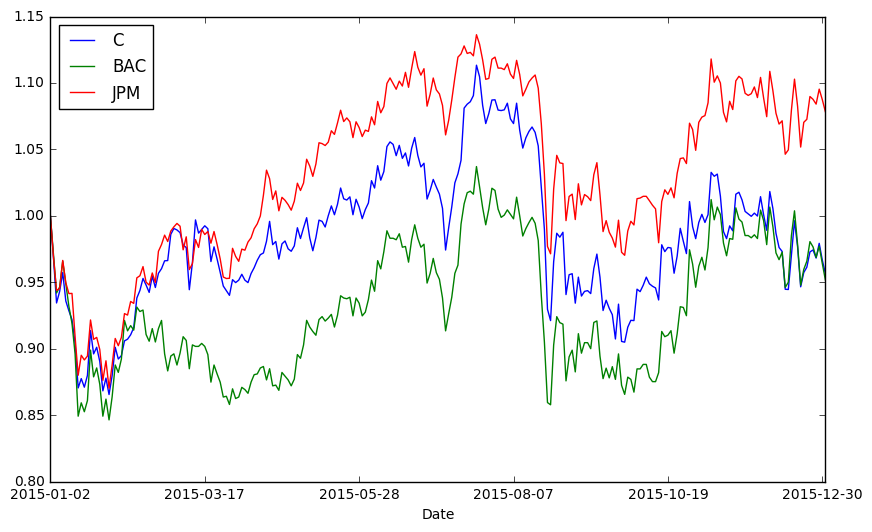

In [45]:
clusters, noClusters = clusteringAlg(corList, k = 30)
plotSetPrices(stockPrices, clusters, 'BAC')

We can see from the above that in this case, the clusters do seem to "make sense" in the sense that they seem to have a similar pattern of price changes over the period.

## The extra part 

### In-depth analysis

#### Algorithm Properties and Complexity

The complexity of the clustering algorithm as discussed above is dependent on both $n$ and $k$, where n is the number of firms, and k is the number of iterations. The number of edges/correlations, $m$, is in this case $e=n(n+1)/2$

The main loop is run k times, up to the point where k > m, at which point the algorithm is no longer able to loop through any more correlations.

A few of properties of the algorithm are as follows:
* After the $k$th iteration, the maximum number of firms in a cluster is min(k+1,n), as one can simply add a link to a "new" node in every iteration, starting from k=0 where all clusters are of size 1, and one can do this up until all nodes have been connected.
* After the $k$th iteration, the minimum number of clusters is max(1,n-k), which corresponds to the case above.
* After the $k$th iteration, the maximum number of clusters is between n and n-k, in fact the maximum number of clusters is n minus the maximum number that when triangled, is less than or equal to n.

For the below, we are interested in cases where k is <= m.

The complexity of the algorithm is O($n^2logn + nk$):

##George
1. Sort the edges in the graph by their weight (ie the correlation) - O($mlogm$), so O($n^2logn$)
2. Create a single-node set from each node in the graph - O($n$)
3. Repeat k times
    1. Pick the highest-weight edge - O($1$) as the list is sorted.
    2. Check whether the clusters are already in the same set - O($n$) to check whether either  the source or destination nodes are in any of the sets.
    3. Merge the sets containing the source and the destination of the edge - O(length(set1) + length(set2)) which is maximally O($n$) if you are making a union of the set of n nodes with itself.
    4. Repeat from A. with the next-highest weight edge
4. Return the remaining sets - O($1$).

##Louise
1. Sort the edges in the graph by their weight (ie the correlation) - O($mlogm$), so O($n^2logn$)
2. Create a single-node set from each node in the graph - O($n$)
3. Repeat k times
    1. Pick the highest-weight edge - O($1$) as the list is sorted.
    2. Check whether the clusters are already in the same set - O($n$) to check the top and bottom node of the source and destination - sets can be maximally n-nodes long
    3. Merge the sets containing the source and the destination of the edge - O(1)
    4. Repeat from A. with the next-highest weight edge
4. Return the remaining sets - O($n$) by looping through all start nodes and all following nodes to add them each to the set.

In practice, at least for the data we have, the implementation of this algorithm can be improved. Two alternative algorithms have been created and their running time for multiple ks compared. 

* Algorithm 1 : As per the above.
* Algorithm 2 : Takes a graph as input, sorts the list of correlations (edges), initialises all firms to be in their own set, then loops k times to merge the source and target set together, and stores the merged in the dictionary once for each firm in the set, after those k iterations it de-duplicates the sets and returns them.
* Algorithm 3 : As per the assignment description, sorts the list of correlations, points all firms to themselves, and then loops k times to find the "bottom node" and "top node" to check if the firms are in the same set, if not then points the bottom node of the source to the start node of the destination, after those k iterations it returns the list of sets based on following each start node to its bottom node.

Our analysis below shows that keeping n constant, Algorithm 1 is less sensitive to k than Algorithm 2, which is in turn less sensitive to k than Algorithm 3. Algorithm 3 seems from our data to be quite linear in k, (the time doubling as k goes from 50,000 to 100,000), whereas for our sample sizes, Algorithm 1 outperforms the others when k is large.

These algorithms are kept in a separate file and are imported for this analysis, their algorithmic complexity is also outlined in the file "ClusteringAlgorithmComparison2".

In [57]:
import ClusteringAlgorithmComparison as cac
import ClusteringAlgorithm2Preprocessing as cpp

In [58]:
##Pre processing for algorithm 2
dailyReturn = cpp.stockReturns(stockPrices)
corr, corrGraph = cpp.calCorrelations(dailyReturn)

For **k=5,000**, the results of the clustering algorithms 1,2,3 are shown below in order:

In [59]:
%timeit results = cac.clusteringAlg1(corList, 5000)

1 loop, best of 3: 1.48 s per loop


In [60]:
%timeit results = cac.clusteringAlg2(corrGraph, 5000)

1 loop, best of 3: 242 ms per loop


In [61]:
%timeit results = cac.clusteringAlg3(corList, 5000)

1 loop, best of 3: 294 ms per loop


For **k=50,000**, the results of the clustering algorithms 1,2,3 are shown below in order:

In [62]:
%timeit results = cac.clusteringAlg1(corList, 50000)

1 loop, best of 3: 1.65 s per loop


In [63]:
%timeit resultslf = cac.clusteringAlg2(corrGraph, 50000)

1 loop, best of 3: 1.49 s per loop


In [64]:
%timeit results = cac.clusteringAlg3(corList, 50000)

1 loop, best of 3: 5.35 s per loop


For **k=100,000**, the results of the clustering algorithms 1,2,3 are shown below in order:

In [65]:
%timeit results = cac.clusteringAlg1(corList, 100000)

1 loop, best of 3: 1.81 s per loop


In [66]:
%timeit resultslf = cac.clusteringAlg2(corrGraph, 100000)

1 loop, best of 3: 2.95 s per loop


In [67]:
%timeit resultslf = cac.clusteringAlg3(corList, 100000)

1 loop, best of 3: 10.9 s per loop


#### Stock correlations of the 5 tech stocks in 2014

In the main section of the report, we looked at the top correlated stocks with the 5 tech companies in 2015. We will now look to see whether these correlations exist in 2014 as well. Stock prices of the S&P500 companies in 2014 were drawn from the Yahoo Finance website and correlations are calculated based on the data.

In [ ]:
#pull stock tickers from S&P500 list and convert them into a list

stocktickers = corMatrix.columns
stocktickers = list(stocktickers)

To pull data from the Yahoo Finance website, we used helper functions from hw2.py to generate the helper function `getStockfromYahoo`, which requires two inputs: the year of the data and the list of stock tickers of interest. It returns a dataframe of stock prices over the year for the specified stocks.

In [ ]:
import pandas_datareader.data as web
from datetime import datetime

#additional helper functions from hw2.py file

def getStock(symbol, start, end):
    """
    Downloads stock price data from Yahoo Finance
    Returns a pandas dataframe.
    """
    df =  web.DataReader(symbol, 'yahoo', start, end)
    return df

def getClose(df):
    """
    Returns stock price dataframe's adjusted closing price as a list
    """
    L = df['Adj Close'].values.tolist()
    return L

In [ ]:
def getStockfromYahoo(year, stocktickers):
    start = datetime(year,1,1)
    finish = datetime(year,12,31)
    stockdf = DataFrame()
    a = 0
    
    for i in stocktickers:
        try:
            if a == 0:
                stock = getStock(i,start, finish)
                stock = stock.loc[:, 'Close']
                stockdf = DataFrame(stock)
                stockdf = stockdf.rename(columns={'Close': i})
                a = a + 1
            else:            
                stock = getStock(i,start, finish)
                stock = stock.loc[:, 'Close']
                stockdf = stockdf.join(stock)
                stockdf = stockdf.rename(columns={'Close': i})
        except:
            pass
    
    return stockdf

In [ ]:
#create dataframe with stock prices

data_2014 = getStockfromYahoo(2014, stocktickers)

In [ ]:
#calculate stock returns for 2014 data

sr_2014 = stockReturns(data_2014)

In [ ]:
#create correlation matrix for 2014

corr_2014 = calCorrelations(sr_2014)[0]

In [ ]:
#top and bottom correlated companies for FB

pd.DataFrame(highLowCorrelation(corr_2014, 'FB')[0])

In [ ]:
pd.DataFrame(highLowCorrelation(corr_2014, 'FB')[1])

In [ ]:
#correlation between BRK-B and MSFT

cal2CompCor(corr_2014, firms, 'BRK-B', 'MSFT')

When we looked at the top and bottom correlated stocks for the 5 tech companies in 2014, we saw a change in the results. For example, for Facebook in 2015, the top correlated companies were mostly from the IT industry, but in 2014, it was most highly correlated with companies from the healthcare industry.

Overall, most of the companies which had the highest correlation with the 5 tech companies in 2015 did not appear in the top 5 correlated companies in 2014, which suggests that many of the surprising results seen before e.g. Starbucks stocks having high correlation with Facebook stocks in 2015, were probably due to chance. (Starbucks stocks and Facebook stocks have a correlation of 0.60 and 0.34 in 2015 and 2014 respectively)

On the other hand, for Microsoft and Berkshire-Hathaway, we still find positive correlation between the two stocks in 2014, though not as strong (0.59 in 2015, 0.43 in 2014). This is interesting because though the two companies are from different industries, their stocks are moderately correlated over a period of two years. This may warrant further investigation, to see whether this relationship exists over an even longer period of time.

### Exploring other clustering methods

In [ ]:
def getStockDetails(ticker, clusterSets, firmDF):
    
    # if the ticker given is in a single set cluster
    if {ticker} in clusterSets:
        return firmDF.loc[ticker, :]
    else:
        for i in range(len(clusterSets)):
            if ticker in clusterSets[i]:
                return firmDF.loc[clusterSets[i], :].sort_values(['Sector', 'Name'])

#### Average Linkage Clustering 

The first alternative clustering algorithm we will be looking at is Average Linkage Clustering. Both Average-Linkage Clustering and Single-Linkage Clustering are subtypes of Agglomerative Hierarchical Clustering. The difference between these two clustering methods is the definition of 'shortest distance'. Note that in our earlier example, correlation between stocks was used to represent similarities. We can think of correlation as the inverse of 'distance' between the nodes.  

In single-linkage clustering, the distance between two clusters is determined by a single element pair (one from each cluster) which are closest to each other. The algorithm always chooses the shortest of these links while merging two clusters. While merging cluster, other than the aforementioned element pair, single-linkage clustering disregards the distances to all other elements in the cluster. Consequently, it tends to produce large cluster where certain pairs of elements are dissimilar to each other.  

However, in average-linkage clustering, the distance between two clusters is defined as the average of all distances between pairs of objects (each from the two distinct clusters). This helps to prevent the so-called chaining phenomenon experienced by single-linkage clustering, where many of the elements in each cluster may be very dissimilar.  

##### Python Code  

The following section includes the Python code in performing average-linkage clustering using scikit-learn. Since the scikit-learn function requires a distance matrix, we will need to convert the correlation matrix into distance matrix.    

Convert the correlation matrix into distance matrix. Correlation is within the interval [-1, 1] and a higher value reflects greater similarity. We'll need to transform correlation value into distance, hence we get the absolute value of (correlation - 1). The resulting value will be a distance within interval [0, 2] and a higher value reflects lower similarity.  

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def stockClusteringAgglomerative(corrDF, num_clusters):
    
    # Store column names as company's ticker symbol
    compTickers = corrDF.columns
    
    # Transform correlation matrix into distance matrix
    affinityMatrix = abs(corrDF.as_matrix() - 1)
    
    # Run agglomerative clustering with average-linkage with precomputed distance matrix
    model = AgglomerativeClustering(linkage = 'average', affinity = 'precomputed', n_clusters = num_clusters)
    aggFit = model.fit(affinityMatrix)
    
    resultSets = [set()] * num_clusters
    i = 0
    
    # Return the clustering results in the form of "list of sets", each set representing a cluster
    for l in aggFit.labels_:
        resultSets[l] = resultSets[l].union({compTickers[i]})
        i += 1
        
    return resultSets

#### K-Means Clustering 

The second clustering algorithm we use is K-Means Clustering. To use K-Means clustering, we need to define the "features" of each node. Correlation only provides the distance between each node and hence is not sufficient for K-Means clustering. In this case, we define the features to be daily price change (in percentage) of each individual stock. This information is contained in the daily return matrix where each column contains the daily price change in terms of percentage.  

K-Means clustering attempts to fit K number of centroids to the dataset such that the total sum of distance from each node to its corresponding centroid is minimised. One characterisitc of K-Means clustering is that it tends to separate data into clusters of roughly equal size. In other words, it assumes the data distribution to be separable with K spherical clusters. This might not work well on certain data where this assumption does not hold true.  

Lastly, since K-Means clustering assumes the data to be separable using K spherical clusters of roughly equal size, the choice of K value is key. A bad choice of K can lead to bad results. We will explore this in later section.  

##### Python Code  

The following section includes the Python code in performing K-Means clustering using scikit-learn. As mentioned above, K-Means clustering function requires a list of vectors defining the "features" of each stock. We will use the daily return for K-Means clustering algorithm.  

In [ ]:
from sklearn.cluster import KMeans

def stockClusteringKMeans(dailyReturn, num_clusters):
    
    # Store column names as company's ticker symbol
    compTickers = dailyReturn.columns
    
    # Transpose the daily return matrix so that each row contains all the price changes of a particular stock
    dailyReturnArray = dailyReturn.as_matrix().transpose()
    
    # Run K-Means clustering with random centroid initialisation
    kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(dailyReturnArray)
    
    resultSets = [set()] * num_clusters
    i = 0
    
    # Return the clustering results in the form of "list of sets", each set representing a cluster
    for l in kmeans.labels_:
        resultSets[l] = resultSets[l].union({compTickers[i]})
        i += 1
    
    return resultSets

#### Clustering Results Comparison

##### Single-Linkage Clustering (K = 1000, Number of Clusters = 327)

As seen in earlier section, the "greedy" clustering algorithm (a.k.a. single-linkage clustering) tends to produce a very large cluster with dissimilar elements within the same cluster when K is large. For instance, it groups the following stocks within the same cluster as Bank of America (BAC).  

In [ ]:
clusters, noClusters = clusteringAlg(corList, k = 1000)

getStockDetails('BAC', clusters, firms)

We can notice that there are many non-financials stocks in this cluster. Many Consumer Discretionary, Health Care, Industrials and Information Technology stocks have been mis-classified under this cluster. This demonstrates the weakness of single-linkage clustering: it produces long thin clusters where nearby elements are similar, but elements at the opposite ends of a cluster may be very dissimilar.  

##### Average-Linkage Clustering (Number of Clusters = 327)

Next, we will see how average linkage clustering addresses this issue. The average-linkage clustering is invoked to produce equally many clusters as the "greedy" single-linkage clustering algorithm.  

The below table tabulates the list of companies within the same cluster as Bank of America if average-linkage clustering is used.  

In [ ]:
# Call cluster-linkage clustering using correlation DF, and num_cluster = number of clusters produced earlier
clusterAggAveLinkage = stockClusteringAgglomerative(corMatrix, len(clusters))

getStockDetails('BAC', clusterAggAveLinkage, firms)

As we can see, this cluster remains of manageable size and all the companies within this cluster are financials companies. All the elements are rather similar to each other, compared with the results obtained from single-linkage clustering.  

While computing the distance between two clusters, average-linkage clustering considers the average distance between all the element pairs from the two clusters and this has evidently produced a better clustering results than the "greedy" single-linkage clustering.  

### K-Means Clustering (K = 327)

Lastly, we shall inspect the clusters formed using K-Means clustering algorithm. We shall invoke the K-Means clustering algorithm to produce equally many clusters as the "greedy" single-linkage clustering algorithm.  

Let's find out which cluster Bank of America belongs to.  

In [ ]:
# Construct the daily returns data frame again
dailyReturns = stockReturns(stockPrices)

# Call K-Means clustering using daily return DF, and num_cluster = number of clusters produced earlier
clusterKMeans = stockClusteringKMeans(dailyReturns, len(clusters))

getStockDetails('BAC', clusterKMeans, firms)

As mentioned in earlier section, K-Means clustering tends to separate the data into clusters of equal size. A high value of K would separate the companies into many small clusters. As we can see from the above table, the cluster (which Bank of America belong to) is a much smaller cluster with only 8 financials companies.  

Other financials companies are separated into different clusters, such as Zions Bancrop:

In [ ]:
getStockDetails('ZION', clusterKMeans, firms)

And U.S. Bancorp:

In [ ]:
getStockDetails('USB', clusterKMeans, firms)

In this run of the K-Means Clustering algorithm, K is a very high number, 327. As we can see, a high number of K performs very granular division and separates similar financials companies into different clusters. A smaller number of K might potentially yield better results.  

### K-Means Clustering Revisited (K = 50)  

Since a high K value may give us too many small and granular clusters, we shall now try a lower value of K. In this section, we will rerun the algorithm with K = 50 and find out what other companies are in the same cluster as Bank of America.  

In [ ]:
# Re-run K-Means clustering with num_cluster = 50
clusterKMeans = stockClusteringKMeans(dailyReturns, 50)

getStockDetails('BAC', clusterKMeans, firms)

This time, the cluster is much larger and contains the other relevant financials companies. By reducing K, K-Means clustering divides the companies into a bigger cluster of similar companies.  

However, recall that K-Means clustering expects all the clusters to be of similar size. Reducing K also result in an unnecessarily large cluster like below.  

In [ ]:
getStockDetails('JNJ', clusterKMeans, firms)

Johnson & Johnson, a pharmaceutical company, is correctly placed under the Health Care cluster. However, some companies in other sectors (such as Consumer Discretionary, Consumer Staples, Financials and Industrials) are also placed in the same cluster. As we can see, a lower K value results in overly large clusters with dissimilar companies.  

In conclusion, the choice of K is crucial in producing an accurate clustering result. Some diagnostic checks can be performed on the data in order to determine the near-optimal choice. Also, the assumption of near-equal sized spherical cluster may not hold true for certain data distribution and it may be better to use other clustering algorithms in our case (in clustering different stocks within S&P 500).

# Notes

*Any notes or comments about the report to be listed here:*

* 